In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'mejiro':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import numpy as np
import time
from pprint import pprint
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from lenstronomy.Util import data_util
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman

from mejiro.pandeia import pandeia_input
from mejiro.helpers import test_physical_lens, test_physical_lens_2
from mejiro.plots import plot, diagnostic_plot

plt.style.use(f'{repo_path}/mejiro/mplstyle/science.mplstyle')

In [3]:
figure_dir = os.path.join(repo_path, 'figures')
array_dir = os.path.join(repo_path, 'output', 'arrays')

lens = test_physical_lens.TestPhysicalLens()
lens_2 = test_physical_lens_2.TestPhysicalLens2()

In [4]:
csv = os.path.join(repo_path, 'data', 'roman_spacecraft_and_instrument_parameters.csv')
roman_params = pd.read_csv(csv)
roman_pixel_scale = float(roman_params.loc[roman_params['Name'] == 'WFI_Pixel_Scale']['Value'].to_string(index=False))

lenstronomy_roman_config = Roman(band='F106', psf_type='PIXEL', survey_mode='wide_area').kwargs_single_band()
magnitude_zero_point = lenstronomy_roman_config.get('magnitude_zero_point')

In [33]:
num_samples = 10000
grid_oversample = 5
side = 5.5
num_pix = round(side / roman_pixel_scale)

# if num_pix even, need to make it odd
if num_pix % 2 == 0:
    num_pix += 1

In [34]:
model = lens.get_array(num_pix=num_pix, side=side)

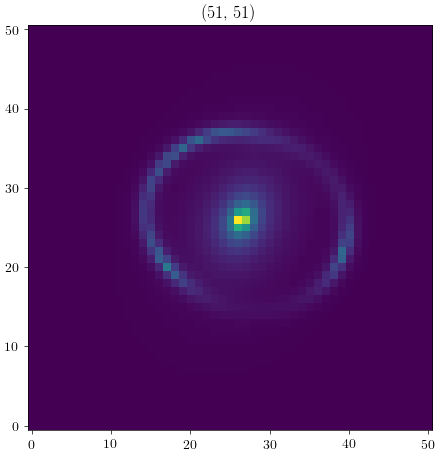

In [35]:
plot.plot(model, title=model.shape)

In [36]:
calc, _ = pandeia_input.build_pandeia_calc(csv=csv, 
                                        array=model, 
                                        lens=lens, 
                                        band='f106', 
                                        num_samples=num_samples)

  0%|          | 0/51 [00:00<?, ?it/s]/data/bwedig/.conda/envs/pandeia/lib/python3.9/site-packages/lenstronomy/Util/data_util.py:67: RuntimeWarning: divide by zero encountered in log10
  delta_m = -np.log10(cps) * 2.5
100%|██████████| 1247/1247 [00:08<00:00, 144.94it/s]

Point source conversion complete: placed 1247 point sources
Estimated calculation time: 0:01:30


In [37]:
detector, execution_time = pandeia_input.get_pandeia_image(calc)

Performing Pandeia calculation...
Pandeia calculation complete in 0:01:57


/data/bwedig/.conda/envs/pandeia/lib/python3.9/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


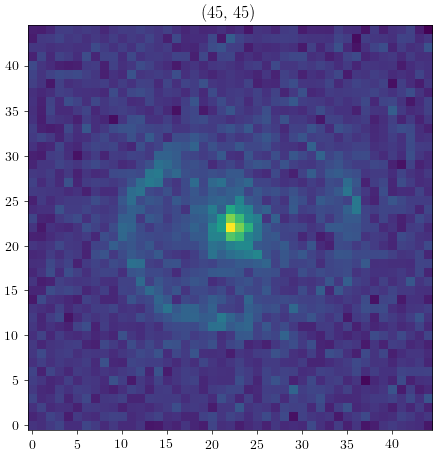

In [38]:
plot.plot(detector, title=detector.shape)

In [39]:
# calculate how much to crop off model
crop_pix = int((model.shape[0] - detector.shape[0]) / 2)
start = crop_pix
end = model.shape[0] - crop_pix
cropped_model = model[start:end, start:end]

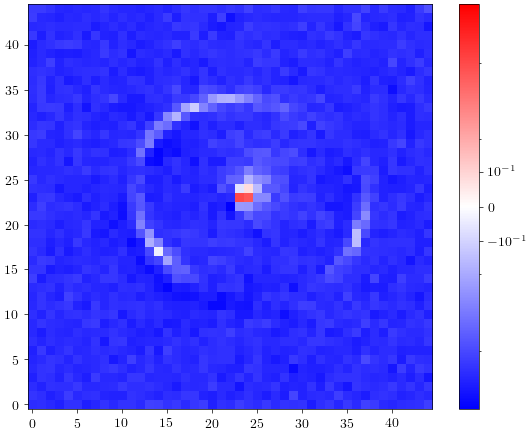

In [40]:
diagnostic_plot.residual(cropped_model, detector)